In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from simglucose.envs.simglucose_gym_env import T1DSimEnv

In [2]:
def discretize_glucose(glucose, bins=[70, 120, 180]):
    # Bins: <70, 70-120, 120-180, >180
    if glucose < bins[0]:
        return 0
    elif glucose < bins[1]:
        return 1
    elif glucose < bins[2]:
        return 2
    else:
        return 3

In [3]:
action_space = np.arange(0, 6.5, 0.5) # e.g. 0, 0.5, ..., 6
n_actions = len(action_space)
n_states = 4 # Based on discretize_glucose

In [4]:
def reward_fn(glucose):
    if glucose < 70:
        return -100 * (70 - glucose)
    elif glucose > 180:
        return -100 * (glucose - 180)
    else:
        return 100

In [16]:
class TDControlAgent:
    def __init__(self, n_states, n_actions, gamma=0.99, lr=0.1, alg="sarsa"):
        self.gamma = gamma
        self.lr = lr
        self.n_states = n_states
        self.n_actions = n_actions
        self.Qvalues = np.zeros((n_states, n_actions))
        self.alg = alg # "sarsa" or "qlearning"
        
    def get_action_epsilon_greedy(self, s, eps):
        if np.random.rand() < eps:
            return np.random.randint(self.n_actions)
        else:
            best_value = np.max(self.Qvalues[s])
            best_actions = (self.Qvalues[s] == best_value)
            prob_actions = best_actions / np.sum(best_actions)
            return np.random.choice(self.n_actions, p=prob_actions)
        
    def single_step_update(self, s, a, r, new_s, new_a=None, done=False):
        if self.alg == "sarsa":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * self.Qvalues[new_s, new_a] - self.Qvalues[s, a]
        elif self.alg == "qlearning":
            if done:
                deltaQ = r - self.Qvalues[s, a]
            else:
                deltaQ = r + self.gamma * np.max(self.Qvalues[new_s]) - self.Qvalues[s, a]
        else:
            raise ValueError("Unknown algorithm")
        self.Qvalues[s, a] += self.lr * deltaQ

In [17]:
env = T1DSimEnv()
agent = TDControlAgent(n_states=n_states, n_actions=n_actions, gamma=0.99, lr=0.1, alg="sarsa") # or "sarsa"
epsilon = 0.1
num_episodes = 1000
performance = np.zeros(num_episodes)

In [18]:
for episode in range(num_episodes):
    obs = env.reset()
    if isinstance(obs, tuple):
        obs = obs[0]
    # Extract glucose value robustly
    if hasattr(obs, "CGM"):
        glucose = obs.CGM
    elif isinstance(obs, dict) and 'CGM' in obs:
        glucose = obs['CGM']
    elif isinstance(obs, (np.ndarray, list)):
        glucose = obs[0]
    elif isinstance(obs, (float, int)):
        glucose = obs
    else:
        raise ValueError(f"Unknown observation format: {type(obs)}")

    s = discretize_glucose(glucose)
    a = agent.get_action_epsilon_greedy(s, epsilon)
    done = False
    while not done:
        insulin_dose = action_space[a]
        step_result = env.step(insulin_dose)
        if isinstance(step_result, tuple) and len(step_result) == 4:
            next_obs, _, done, info = step_result
        else:
            next_obs = step_result
            done = False

        if hasattr(next_obs, "CGM"):
            next_glucose = next_obs.CGM
        elif isinstance(next_obs, dict) and 'CGM' in next_obs:
            next_glucose = next_obs['CGM']
        elif isinstance(next_obs, (np.ndarray, list)):
            next_glucose = next_obs[0]
        elif isinstance(next_obs, (float, int)):
            next_glucose = next_obs
        else:
            raise ValueError(f"Unknown observation format: {type(next_obs)}")

        r = reward_fn(next_glucose)
        performance[episode] += r
        new_s = discretize_glucose(next_glucose)
        if agent.alg == "sarsa":
            new_a = agent.get_action_epsilon_greedy(new_s, epsilon)
            agent.single_step_update(s, a, r, new_s, new_a, done)
            s, a = new_s, new_a
        else:  # Q-learning
            agent.single_step_update(s, a, r, new_s, done=done)
            s = new_s
            a = agent.get_action_epsilon_greedy(s, epsilon)

print("Training complete. Use agent.Qvalues for the learned policy.")

Training complete. Use agent.Qvalues for the learned policy.


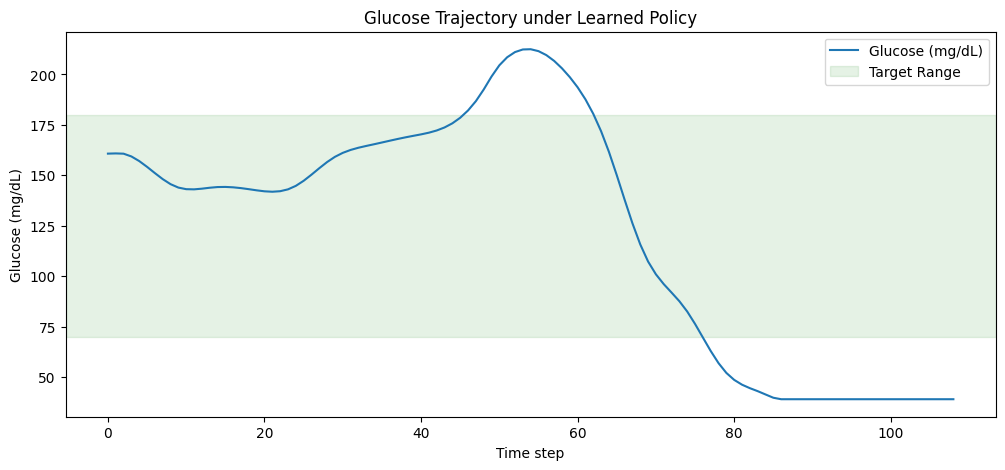

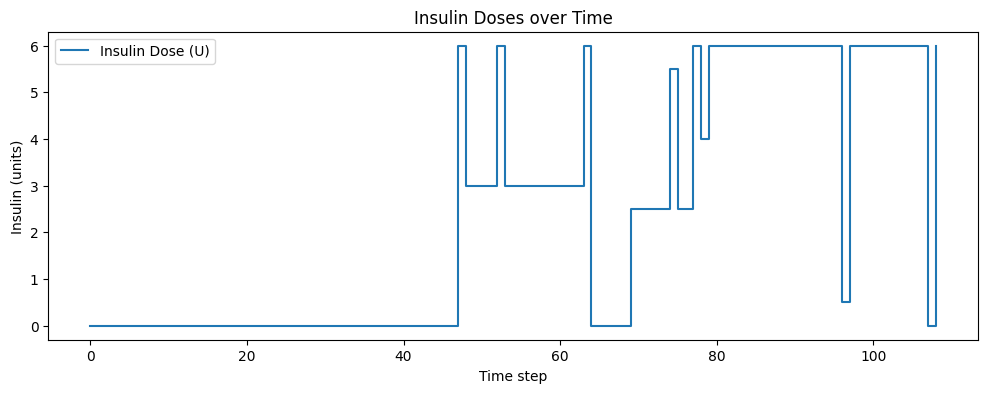

In [12]:
import matplotlib.pyplot as plt

# Set epsilon=0 for greedy policy (pure exploitation)
epsilon_eval = 0.1

# Start a new episode
obs = env.reset()
if isinstance(obs, tuple):
    obs = obs[0]
if hasattr(obs, "CGM"):
    glucose = obs.CGM
elif isinstance(obs, dict) and 'CGM' in obs:
    glucose = obs['CGM']
elif isinstance(obs, (np.ndarray, list)):
    glucose = obs[0]
elif isinstance(obs, (float, int)):
    glucose = obs
else:
    raise ValueError(f"Unknown observation format: {type(obs)}")

s = discretize_glucose(glucose)
a = agent.get_action_epsilon_greedy(s, epsilon_eval)
done = False

# Lists to record data
G_t = [glucose]
I_t = [action_space[a]]
rewards = []
times = [0]
t = 0

while not done:
    insulin_dose = action_space[a]
    step_result = env.step(insulin_dose)
    if isinstance(step_result, tuple) and len(step_result) == 4:
        next_obs, _, done, info = step_result
    else:
        next_obs = step_result
        done = False
    
    if hasattr(next_obs, "CGM"):
        next_glucose = next_obs.CGM
    elif isinstance(next_obs, dict) and 'CGM' in next_obs:
        next_glucose = next_obs['CGM']
    elif isinstance(next_obs, (np.ndarray, list)):
        next_glucose = next_obs[0]
    elif isinstance(next_obs, (float, int)):
        next_glucose = next_obs
    else:
        raise ValueError(f"Unknown observation format: {type(next_obs)}")
    
    r = reward_fn(next_glucose)
    rewards.append(r)
    G_t.append(next_glucose)
    I_t.append(insulin_dose)
    t += 1
    times.append(t)
    
    s = discretize_glucose(next_glucose)
    a = agent.get_action_epsilon_greedy(s, epsilon_eval)

# Plot glucose over time
plt.figure(figsize=(12,5))
plt.plot(times, G_t, label='Glucose (mg/dL)')
plt.axhspan(70, 180, color='green', alpha=0.1, label='Target Range')
plt.xlabel('Time step')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose Trajectory under Learned Policy')
plt.legend()
plt.show()

# Optional: Plot insulin doses
plt.figure(figsize=(12,4))
plt.step(times, I_t, label='Insulin Dose (U)', where='post')
plt.xlabel('Time step')
plt.ylabel('Insulin (units)')
plt.title('Insulin Doses over Time')
plt.legend()
plt.show()